### Cab-Driver Agent

In [2]:
# Importing libraries
import numpy as np
import random
import math
import time
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

C:\Users\ragarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# Initialise States_tracked as 'States_track' (for convergence)

States_track = collections.defaultdict(dict)

print(len(States_track))

0


In [4]:
#This function will initialise the 5 Q-values which need to be tracked for checking convergence

#iters = []                            #the x-axis of convergence graphs

def initialise_tracking_states():
    sample_q_values = [[(0,1,5),(0,2)],[(1,23,2),(3,4)],[(2,16,1),(2,4)],[(3,18,6),(2,0)],[(4,2,0),(4,1)]]  #select any 5 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [5]:
def save_tracking_states(agent):
    for state in States_track.keys():
        for action in States_track[state].keys():
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, env.state_size])
            q_value = agent.model.predict(state_encod)
            action_index = env.action_space.index(action)
            States_track[state][action].append(q_value[0][action_index])

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001     
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        self.batch_size = 32        
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
       
        model.add(Dense(64, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model



    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment  
        
        possible_actions_index, actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        
        if np.random.rand() <= epsilon:
            
            action_index = np.random.choice(possible_actions_index) #Exploration: randomly choosing any action
            action = env.action_space[action_index]
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            
            possible_q_value = [q_value[0][i] for i in possible_actions_index]
            max_q_value_index = np.argmax(possible_q_value)
            action_index = possible_actions_index[max_q_value_index]
            action = actions[max_q_value_index]
            
        return action, action_index, epsilon
    

    def append_sample(self, state, action_index, reward, next_state, terminal_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        
        # Adding sample to the memory. 
        self.memory.append((state, action_index, reward, next_state, terminal_state))
        

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # Write your code from here
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action_index, reward, next_state, terminal_state = mini_batch[i]
                state_encod = env.state_encod_arch1(state)
                #state_encod = np.reshape(state, [1, self.state_size])
                
                next_state_encod = env.state_encod_arch1(next_state)
                #next_state_encod = np.reshape(state, [1, self.state_size])
                
                update_input[i] = state_encod
                actions.append(action_index)
                rewards.append(reward)
                terminal_states.append(terminal_state)
                update_output[i] = next_state_encod
                           
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_val = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch

            # Update the target value according to the update policy of Q-learning
            # R_t + γ ∗ max Q_t(S_{t+1},a)−Q_t(S_t,a_t)
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    # Q Learning: get maximum Q value at s' from target model
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (
                     np.amax(target_val[i]))
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size,
                           epochs=1, verbose=0)



    def save(self, name):
        self.model.save_weights(name)

In [8]:
Episodes = 20000

### DQN block

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2368      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                1365      
Total params: 7,893
Trainable params: 7,893
Non-trainable params: 0
_________________________________________________________________
episode: 0   total reward: 0.0  step_count: 143   memory length: 143   epsilon: 1.0
episode: 25   total reward: -185.0  step_count: 142   memory length: 2000   epsilon: 0.9925280548938579
episode: 50   total reward: -567.0  step_count: 122   memory length: 2000   epsilon: 0.9851119397519432
episode: 75   total reward: -298.0  step_count: 153   memory length: 2000   epsilon: 0.9777512374158239
episode:

episode: 1800   total reward: 283.0  step_count: 137   memory length: 2000   epsilon: 0.5827482565465072
episode: 1825   total reward: 175.0  step_count: 153   memory length: 2000   epsilon: 0.5783939935940685
episode: 1850   total reward: 206.0  step_count: 142   memory length: 2000   epsilon: 0.5740722654557134
episode: 1875   total reward: 156.0  step_count: 155   memory length: 2000   epsilon: 0.5697828290330947
episode: 1900   total reward: 480.0  step_count: 132   memory length: 2000   epsilon: 0.5655254430442828
episode: 1925   total reward: 573.0  step_count: 136   memory length: 2000   epsilon: 0.5612998680101929
episode: 1950   total reward: 494.0  step_count: 139   memory length: 2000   epsilon: 0.5571058662411154
episode: 1975   total reward: 360.0  step_count: 112   memory length: 2000   epsilon: 0.5529432018233448
episode: 2000   total reward: 466.0  step_count: 142   memory length: 2000   epsilon: 0.5488116406059101
episode: 2025   total reward: 602.0  step_count: 138   

episode: 3750   total reward: 720.0  step_count: 154   memory length: 2000   epsilon: 0.324652474111825
episode: 3775   total reward: 805.0  step_count: 147   memory length: 2000   epsilon: 0.3222266886971499
episode: 3800   total reward: 479.0  step_count: 145   memory length: 2000   epsilon: 0.31981902861811373
episode: 3825   total reward: 714.0  step_count: 136   memory length: 2000   epsilon: 0.31742935844320214
episode: 3850   total reward: 711.0  step_count: 168   memory length: 2000   epsilon: 0.315057543752838
episode: 3875   total reward: 673.0  step_count: 147   memory length: 2000   epsilon: 0.31270345113181935
episode: 3900   total reward: 974.0  step_count: 133   memory length: 2000   epsilon: 0.3103669481618156
episode: 3925   total reward: 728.0  step_count: 157   memory length: 2000   epsilon: 0.30804790341391863
episode: 3950   total reward: 783.0  step_count: 140   memory length: 2000   epsilon: 0.30574618644125
episode: 3975   total reward: 684.0  step_count: 145   

episode: 5700   total reward: 909.0  step_count: 185   memory length: 2000   epsilon: 0.18086580080846418
episode: 5725   total reward: 1305.0  step_count: 154   memory length: 2000   epsilon: 0.17951438153445015
episode: 5750   total reward: 805.0  step_count: 169   memory length: 2000   epsilon: 0.17817305999116792
episode: 5775   total reward: 1152.0  step_count: 169   memory length: 2000   epsilon: 0.17684176072892702
episode: 5800   total reward: 954.0  step_count: 152   memory length: 2000   epsilon: 0.1755204088617929
episode: 5825   total reward: 1053.0  step_count: 164   memory length: 2000   epsilon: 0.17420893006337462
episode: 5850   total reward: 1044.0  step_count: 158   memory length: 2000   epsilon: 0.17290725056264394
episode: 5875   total reward: 1197.0  step_count: 167   memory length: 2000   epsilon: 0.17161529713978585
episode: 5900   total reward: 783.0  step_count: 160   memory length: 2000   epsilon: 0.17033299712207958
episode: 5925   total reward: 1119.0  step

episode: 7650   total reward: 1206.0  step_count: 177   memory length: 2000   epsilon: 0.10076140226068979
episode: 7675   total reward: 1072.0  step_count: 160   memory length: 2000   epsilon: 0.10000851866137064
episode: 7700   total reward: 828.0  step_count: 165   memory length: 2000   epsilon: 0.09926126056703317
episode: 7725   total reward: 1125.0  step_count: 184   memory length: 2000   epsilon: 0.0985195859442125
episode: 7750   total reward: 792.0  step_count: 191   memory length: 2000   epsilon: 0.09778345307351563
episode: 7775   total reward: 1018.0  step_count: 178   memory length: 2000   epsilon: 0.09705282054727445
episode: 7800   total reward: 1264.0  step_count: 161   memory length: 2000   epsilon: 0.09632764726721664
episode: 7825   total reward: 1091.0  step_count: 150   memory length: 2000   epsilon: 0.09560789244215409
episode: 7850   total reward: 1075.0  step_count: 162   memory length: 2000   epsilon: 0.09489351558568804
episode: 7875   total reward: 1454.0  st

episode: 9600   total reward: 790.0  step_count: 176   memory length: 2000   epsilon: 0.0561347722727861
episode: 9625   total reward: 945.0  step_count: 174   memory length: 2000   epsilon: 0.05571533640634315
episode: 9650   total reward: 800.0  step_count: 188   memory length: 2000   epsilon: 0.05529903454170116
episode: 9675   total reward: 738.0  step_count: 195   memory length: 2000   epsilon: 0.054885843261770435
episode: 9700   total reward: 657.0  step_count: 175   memory length: 2000   epsilon: 0.05447573932443258
episode: 9725   total reward: 1094.0  step_count: 192   memory length: 2000   epsilon: 0.054068699661232976
episode: 9750   total reward: 767.0  step_count: 158   memory length: 2000   epsilon: 0.053664701376083215
episode: 9775   total reward: 1109.0  step_count: 169   memory length: 2000   epsilon: 0.05326372174397327
episode: 9800   total reward: 903.0  step_count: 178   memory length: 2000   epsilon: 0.05286573820969308
episode: 9825   total reward: 1061.0  step

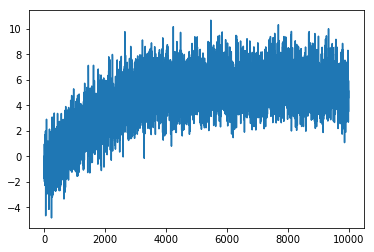

episode: 10025   total reward: 917.0  step_count: 154   memory length: 2000   epsilon: 0.04941507162815284
episode: 10050   total reward: 1064.0  step_count: 192   memory length: 2000   epsilon: 0.049045844996558396
episode: 10075   total reward: 1264.0  step_count: 181   memory length: 2000   epsilon: 0.04867937720611454
episode: 10100   total reward: 891.0  step_count: 195   memory length: 2000   epsilon: 0.04831564764291141
episode: 10125   total reward: 1126.0  step_count: 181   memory length: 2000   epsilon: 0.04795463584706521
episode: 10150   total reward: 656.0  step_count: 199   memory length: 2000   epsilon: 0.047596321511567195
episode: 10175   total reward: 733.0  step_count: 188   memory length: 2000   epsilon: 0.04724068448114156
episode: 10200   total reward: 1062.0  step_count: 173   memory length: 2000   epsilon: 0.04688770475111156
episode: 10225   total reward: 1134.0  step_count: 173   memory length: 2000   epsilon: 0.04653736246627427
episode: 10250   total reward:

episode: 11950   total reward: 630.0  step_count: 185   memory length: 2000   epsilon: 0.0277366773528138
episode: 11975   total reward: 549.0  step_count: 200   memory length: 2000   epsilon: 0.027529430494853777
episode: 12000   total reward: 1023.0  step_count: 189   memory length: 2000   epsilon: 0.027323732174055346
episode: 12025   total reward: 1100.0  step_count: 193   memory length: 2000   epsilon: 0.027119570819833717
episode: 12050   total reward: 573.0  step_count: 205   memory length: 2000   epsilon: 0.02691693494805887
episode: 12075   total reward: 1140.0  step_count: 203   memory length: 2000   epsilon: 0.026715813160409614
episode: 12100   total reward: 905.0  step_count: 195   memory length: 2000   epsilon: 0.02651619414373234
episode: 12125   total reward: 829.0  step_count: 200   memory length: 2000   epsilon: 0.026318066669404745
episode: 12150   total reward: 1118.0  step_count: 195   memory length: 2000   epsilon: 0.02612141959270415
episode: 12175   total reward

episode: 13875   total reward: 1048.0  step_count: 171   memory length: 2000   epsilon: 0.015568597602496211
episode: 13900   total reward: 774.0  step_count: 156   memory length: 2000   epsilon: 0.015452269969386914
episode: 13925   total reward: 657.0  step_count: 174   memory length: 2000   epsilon: 0.015336811529975241
episode: 13950   total reward: 611.0  step_count: 213   memory length: 2000   epsilon: 0.01522221578969351
episode: 13975   total reward: 552.0  step_count: 208   memory length: 2000   epsilon: 0.01510847630250112
episode: 14000   total reward: 504.0  step_count: 194   memory length: 2000   epsilon: 0.014995586670521949
episode: 14025   total reward: 615.0  step_count: 207   memory length: 2000   epsilon: 0.014883540543684399
episode: 14050   total reward: 603.0  step_count: 175   memory length: 2000   epsilon: 0.014772331619364304
episode: 14075   total reward: 944.0  step_count: 187   memory length: 2000   epsilon: 0.014661953642030367
episode: 14100   total reward

episode: 15775   total reward: 622.0  step_count: 229   memory length: 2000   epsilon: 0.008804442333833842
episode: 15800   total reward: 274.0  step_count: 192   memory length: 2000   epsilon: 0.008738656098086835
episode: 15825   total reward: 535.0  step_count: 195   memory length: 2000   epsilon: 0.008673361413486978
episode: 15850   total reward: 504.0  step_count: 179   memory length: 2000   epsilon: 0.008608554607191052
episode: 15875   total reward: 1107.0  step_count: 190   memory length: 2000   epsilon: 0.008544232033799126
episode: 15900   total reward: 862.0  step_count: 210   memory length: 2000   epsilon: 0.008480390075149466
episode: 15925   total reward: 978.0  step_count: 199   memory length: 2000   epsilon: 0.008417025140115076
episode: 15950   total reward: 774.0  step_count: 226   memory length: 2000   epsilon: 0.008354133664401658
episode: 15975   total reward: 592.0  step_count: 233   memory length: 2000   epsilon: 0.00829171211034711
episode: 16000   total rewar

episode: 17675   total reward: 459.0  step_count: 223   memory length: 2000   epsilon: 0.004979140458091775
episode: 17700   total reward: 435.0  step_count: 196   memory length: 2000   epsilon: 0.004941936668260555
episode: 17725   total reward: 813.0  step_count: 182   memory length: 2000   epsilon: 0.004905010863107472
episode: 17750   total reward: 954.0  step_count: 186   memory length: 2000   epsilon: 0.004868360965546257
episode: 17775   total reward: 396.0  step_count: 229   memory length: 2000   epsilon: 0.004831984914010499
episode: 17800   total reward: 263.0  step_count: 215   memory length: 2000   epsilon: 0.004795880662337714
episode: 17825   total reward: 1001.0  step_count: 184   memory length: 2000   epsilon: 0.004760046179654227
episode: 17850   total reward: 812.0  step_count: 222   memory length: 2000   epsilon: 0.004724479450260931
episode: 17875   total reward: 950.0  step_count: 183   memory length: 2000   epsilon: 0.004689178473519925
episode: 17900   total rewa

episode: 19575   total reward: 666.0  step_count: 205   memory length: 2000   epsilon: 0.002815834936654578
episode: 19600   total reward: 658.0  step_count: 191   memory length: 2000   epsilon: 0.002794795247088991
episode: 19625   total reward: 777.0  step_count: 210   memory length: 2000   epsilon: 0.002773912764930463
episode: 19650   total reward: 445.0  step_count: 205   memory length: 2000   epsilon: 0.002753186315533861
episode: 19675   total reward: 612.0  step_count: 161   memory length: 2000   epsilon: 0.0027326147330309454
episode: 19700   total reward: 453.0  step_count: 216   memory length: 2000   epsilon: 0.0027121968602647766
episode: 19725   total reward: 769.0  step_count: 175   memory length: 2000   epsilon: 0.0026919315487246246
episode: 19750   total reward: 530.0  step_count: 197   memory length: 2000   epsilon: 0.0026718176584813735
episode: 19775   total reward: 504.0  step_count: 196   memory length: 2000   epsilon: 0.002651854058123396
episode: 19800   total r

In [9]:
start_time = time.time()

initialise_tracking_states()

env = CabDriver()      #creating an instance of the class

# get size of state and action from environment
state_size = env.state_size 
action_size = env.action_size

#Call the DQN agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    state = env.reset()
    initial_state = state    #for the purpose of tracking reward
    
    terminal_state = False
    step_count = 0
    tot_reward = 0
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        action, action_index, epsilon = agent.get_action(state)
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        
        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action_index, reward, next_state, terminal_state)

        # every time step do the training
        agent.train_model()
        
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            if episode % 25 == 0: #every 25th episode
                print("episode:", episode, "  total reward:", tot_reward, " step_count:",
                      step_count, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
    if episode % 200 == 0:
            agent.save("./cab_driver.h5")

     
    save_obj(avg_reward,'Avg_Rewards')  
    save_obj(total_reward,'Total_Rewards')
    save_tracking_states(agent)
    save_obj(States_track,'States_tracked')   
        
    
    if episode % 10000 ==0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        
elapsed_time = time.time() - start_time

In [10]:
print(elapsed_time)

19453.72692513466


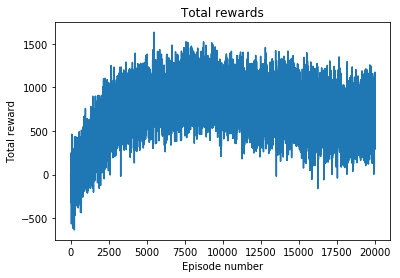

In [24]:
plt.title('Total rewards')
plt.ylabel('Total reward')
plt.xlabel('Episode number')
plt.plot(list(range(len(total_reward))), total_reward)
plt.show()

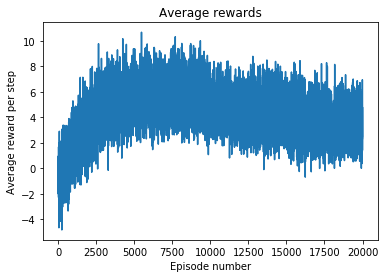

In [25]:
plt.title('Average rewards')
plt.ylabel('Average reward per step')
plt.xlabel('Episode number')
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.show()

### Tracking Convergence

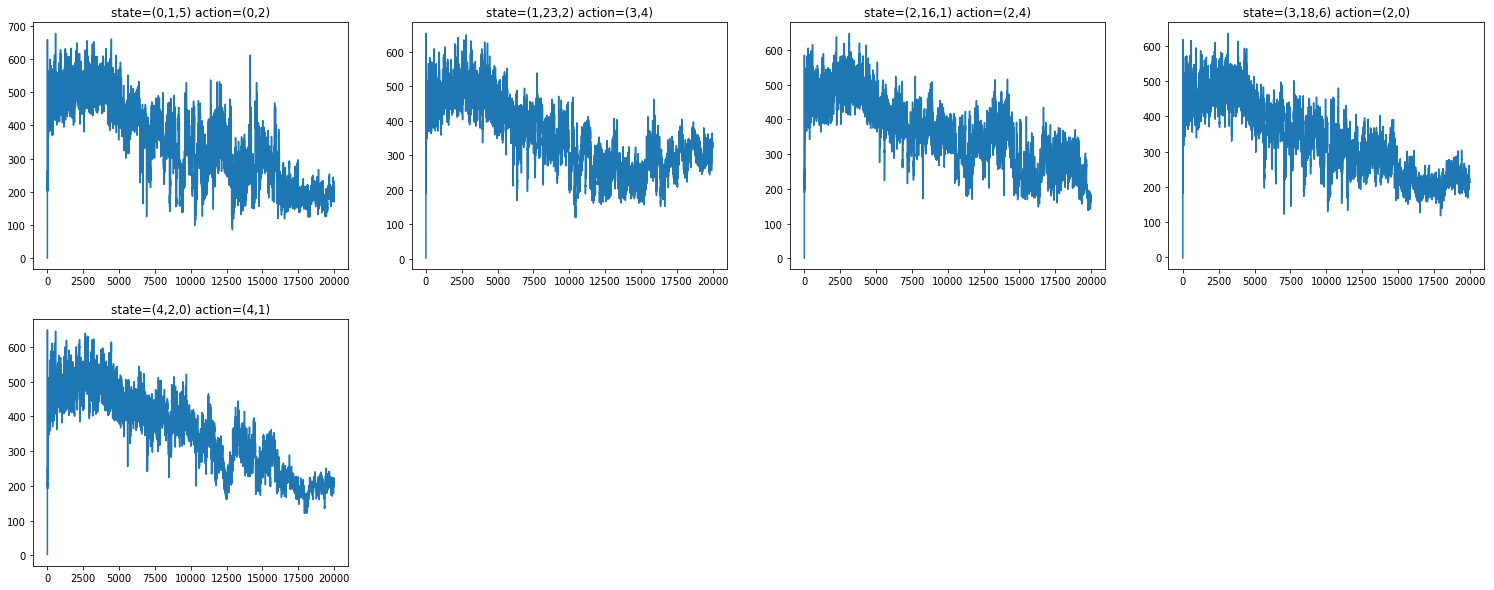

In [20]:
plt.figure(0, figsize=(26,10))

plt.subplot(241)
plt.title('state=(0,1,5) action=(0,2)')
xaxis = np.asarray(range(0, len(States_track[(0,1,5)][(0,2)])))
plt.plot(xaxis,np.asarray(States_track[(0,1,5)][(0,2)]))

plt.subplot(242)
plt.title('state=(1,23,2) action=(3,4)')
xaxis = np.asarray(range(0, len(States_track[(1,23,2)][(3,4)])))
plt.plot(xaxis,np.asarray(States_track[(1,23,2)][(3,4)]))

plt.subplot(243)
plt.title('state=(2,16,1) action=(2,4)')
xaxis = np.asarray(range(0, len(States_track[(2,16,1)][(2,4)])))
plt.plot(xaxis,np.asarray(States_track[(2,16,1)][(2,4)]))

plt.subplot(244)
plt.title('state=(3,18,6) action=(2,0)')
xaxis = np.asarray(range(0, len(States_track[(3,18,6)][(2,0)])))
plt.plot(xaxis,np.asarray(States_track[(3,18,6)][(2,0)]))

plt.subplot(245)
plt.title('state=(4,2,0) action=(4,1)')
xaxis = np.asarray(range(0, len(States_track[(4,2,0)][(4,1)])))
plt.plot(xaxis,np.asarray(States_track[(4,2,0)][(4,1)]))



#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [3]:
time = np.arange(0,20000)
epsilon = []
for i in range(0,20000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0003*i))

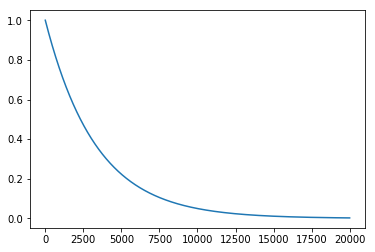

In [4]:
plt.plot(time, epsilon)
plt.show()